In [1]:
import pandas as pd, re
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import calendar
import matplotlib.dates as mdates
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import math
import holidays
from operator import itemgetter

In [2]:
df = pd.read_csv('demandForecastingData.csv', parse_dates=['Date'])

In [3]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Quarter', 'Hour', 'Minute', 'Day', 'Dayofweek', 'Dayofyear']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)
        

In [4]:
add_datepart(df, 'Date', drop=False)

In [5]:
#2018-07-01 00:00:00
#2013-01-01 00:00:00
end_date = datetime(2018, 7, 1)
start_date = datetime(2013, 1, 1)

start_date_displaced_day = start_date - timedelta(minutes=1440)
end_date_displaced_day = end_date - timedelta(minutes=1440)

start_date_displaced_week = start_date - timedelta(minutes=10080)
end_date_displaced_week = end_date - timedelta(minutes=10080)

start_date_displaced_year = start_date - timedelta(minutes=524160)
end_date_displaced_year = end_date - timedelta(minutes=524160)

ranged_df = df[(df.Date >= start_date) & (df.Date <= end_date)].reset_index(drop=True)

df_same_day_displaced  = df[(df.Date >= start_date_displaced_day) & (df.Date <= end_date_displaced_day)].reset_index(drop=True)
df_same_week_displaced  = df[(df.Date >= start_date_displaced_week) & (df.Date <= end_date_displaced_week)].reset_index(drop=True)
df_same_year_displaced  = df[(df.Date >= start_date_displaced_year) & (df.Date <= end_date_displaced_year)].reset_index(drop=True)

ranged_df['Load Last Day'] = df_same_day_displaced['Load']
ranged_df['Load Last Week'] = df_same_week_displaced['Load']
ranged_df['Load Last Year'] = df_same_year_displaced['Load']

ranged_df.head()

,Date,Load,Temperature,Temperature-6hrs,Temperature-12hrs,Temperature-18hrs,Temperature-24hrs,Temperature-36hrs,Temperature-48hrs,Temperature-72hrs,...,Week,Quarter,Hour,Minute,Day,Dayofweek,Dayofyear,Load Last Day,Load Last Week,Load Last Year
0,2013-01-01 00:00:00,840.57,2.7,4.4,6.8,9.9,9.8,8.2,4.7,2.4,...,1,1,0,0,1,1,1,784.39,868.02,865.41
1,2013-01-01 00:30:00,819.25,2.7,4.4,6.8,9.9,9.8,8.2,4.7,2.4,...,1,1,0,30,1,1,1,744.19,805.28,833.36
2,2013-01-01 01:00:00,818.26,2.7,4.0,6.8,10.0,10.1,9.3,5.0,2.4,...,1,1,1,0,1,1,1,743.33,789.54,823.01
3,2013-01-01 01:30:00,799.11,2.7,4.0,6.8,10.0,10.1,9.3,5.0,2.4,...,1,1,1,30,1,1,1,726.10,751.77,809.48
4,2013-01-01 02:00:00,764.40,3.1,3.3,7.2,10.0,10.2,9.6,5.7,2.8,...,1,1,2,0,1,1,1,704.08,709.98,797.16


In [6]:
ni_holidays = holidays.NorthernIreland(years=[2012, 2013, 2014, 2015, 2016])
ni_holidays

{datetime.date(2016, 1, 1): "New Year's Day",
 datetime.date(2016, 3, 17): "St. Patrick's Day",
 datetime.date(2016, 3, 25): 'Good Friday',
 datetime.date(2016, 3, 28): 'Easter Monday',
 datetime.date(2016, 5, 2): 'May Day',
 datetime.date(2016, 5, 30): 'Spring Bank Holiday',
 datetime.date(2016, 7, 12): 'Battle of the Boyne',
 datetime.date(2016, 8, 29): 'Late Summer Bank Holiday',
 datetime.date(2016, 12, 25): 'Christmas Day',
 datetime.date(2016, 12, 27): 'Christmas Day (Observed)',
 datetime.date(2016, 12, 26): 'Boxing Day',
 datetime.date(2012, 1, 1): "New Year's Day",
 datetime.date(2012, 1, 2): "New Year's Day (Observed)",
 datetime.date(2012, 3, 17): "St. Patrick's Day",
 datetime.date(2012, 3, 19): "St. Patrick's Day (Observed)",
 datetime.date(2012, 4, 6): 'Good Friday',
 datetime.date(2012, 4, 9): 'Easter Monday',
 datetime.date(2012, 5, 7): 'May Day',
 datetime.date(2012, 6, 4): 'Spring Bank Holiday',
 datetime.date(2012, 7, 12): 'Battle of the Boyne',
 datetime.date(2012, 

In [7]:
dict_day_count = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
for date, name in sorted(ni_holidays.items()):
    dict_day_count[date.strftime("%A")] += 1
    
dict_day_count

{'Monday': 26,
 'Tuesday': 6,
 'Wednesday': 3,
 'Thursday': 5,
 'Friday': 9,
 'Saturday': 3,
 'Sunday': 4}

In [8]:
# format_date = lambda date: date.strftime('%Y-%m-%d')
format_date = lambda date: date.date()
ranged_df['Date_Format'] = ranged_df.Date.apply(format_date)

C:\Users\jrbai\AppData\Local\conda\conda\envs\load_forecasting_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Monday 0.9618003518477021
Tuesday 0.9691780602662973
Wednesday 0.9692845205151456
Thursday 0.9692874859010421
Friday 0.9695607757970303
Saturday 0.9662153572674518
Sunday 0.9685272597648884


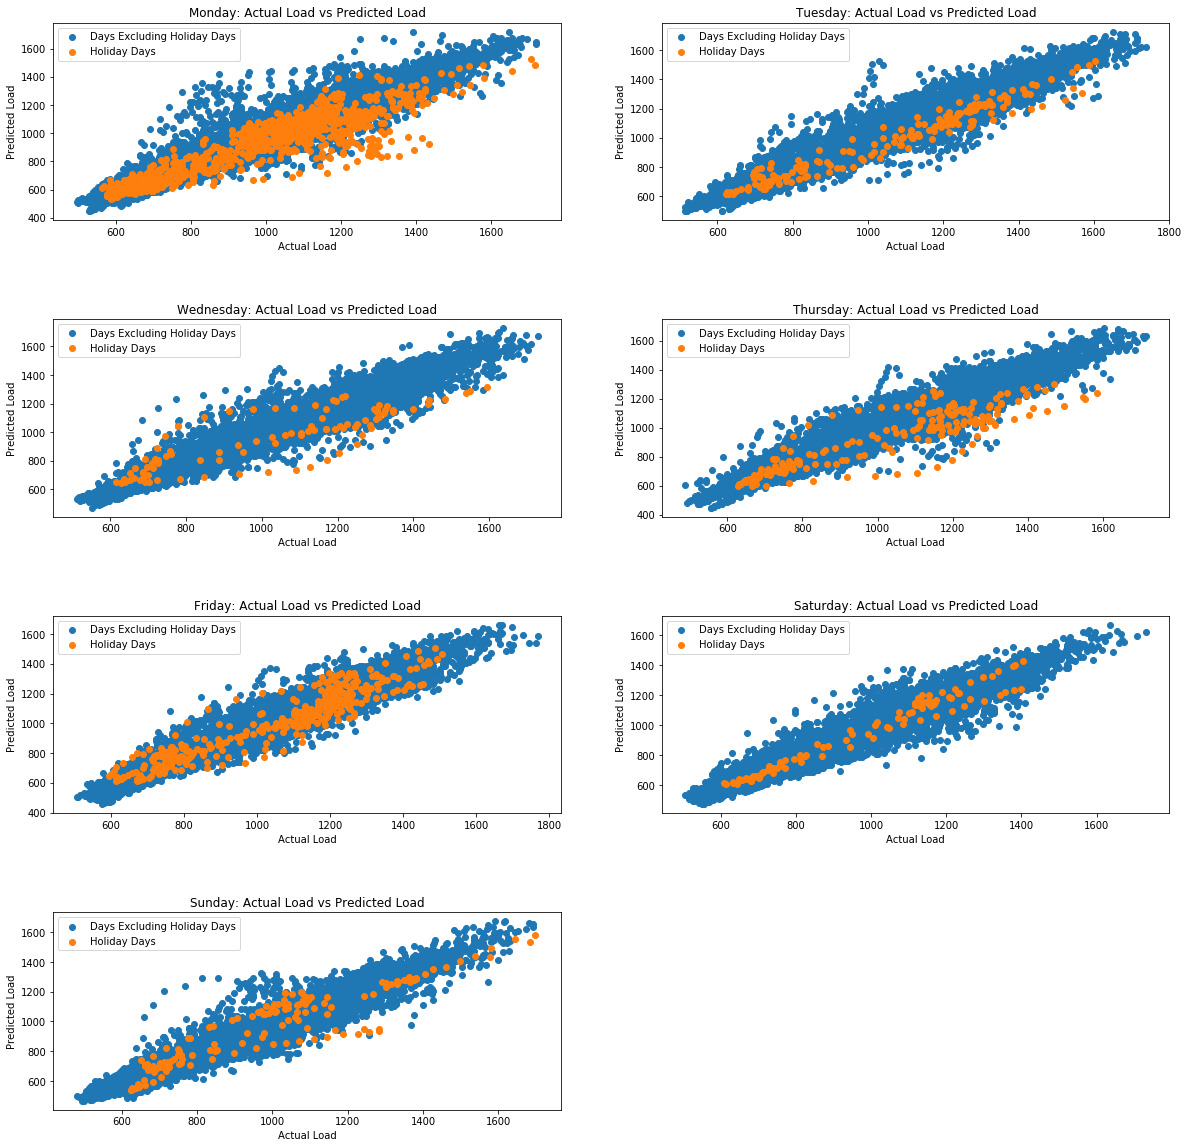

In [9]:
plt.figure(figsize=(20,20))
df_exclude_2018 = ranged_df[ranged_df.Year != 2018]
df_exclude_2018['Holiday'] = df_exclude_2018['Date_Format'].isin(ni_holidays)
for i in range(0, 7):
    plt.subplot(4, 2, i+1)
    plt.title(i)
    specificday = df_exclude_2018[(df_exclude_2018['Dayofweek'] == i) & (df_exclude_2018['Holiday'] == False)]
    specificday_holiday = df_exclude_2018[(df_exclude_2018['Dayofweek'] == i) & (df_exclude_2018['Holiday'] == True)]
    plt.scatter(specificday['Load Last Year'], specificday['Load'])
    plt.scatter(specificday_holiday['Load Last Year'], specificday_holiday['Load'])
    plt.legend(['Days Excluding Holiday Days','Holiday Days'])
    plt.title(f'{calendar.day_name[i]}: Actual Load vs Predicted Load')
    plt.ylabel('Predicted Load')
    plt.xlabel('Actual Load')
    correlation_specificday = specificday.corr()['Load']['Load Last Year']
    print(f'{calendar.day_name[i]} {correlation_specificday}')
    
plt.subplots_adjust(hspace = 0.5)

<b> General trend of overforecasting the load on holiday days - people being less active and staying in the house and not in work </b>

In [10]:
# format_date = lambda date: date.strftime('%Y-%m-%d')
format_date = lambda date: date.date()
ranged_df['Date_Format'] = ranged_df.Date.apply(format_date)
df_exclude_2018 = ranged_df[ranged_df.Year != 2018]
df_exclude_2018['Holiday'] = df_exclude_2018['Date_Format'].isin(ni_holidays)

C:\Users\jrbai\AppData\Local\conda\conda\envs\load_forecasting_env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
def is_derived_holiday(row):
    date = row.Date
    derived_date = date - timedelta(minutes=10080)
    if derived_date in ni_holidays:
        return True
    return False

C:\Users\jrbai\AppData\Local\conda\conda\envs\load_forecasting_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Monday 0.958128815579775
Tuesday 0.9689540642583846
Wednesday 0.9686422147725161
Thursday 0.968414263893555
Friday 0.9687946541139228
Saturday 0.966354915110208
Sunday 0.9693659361589634


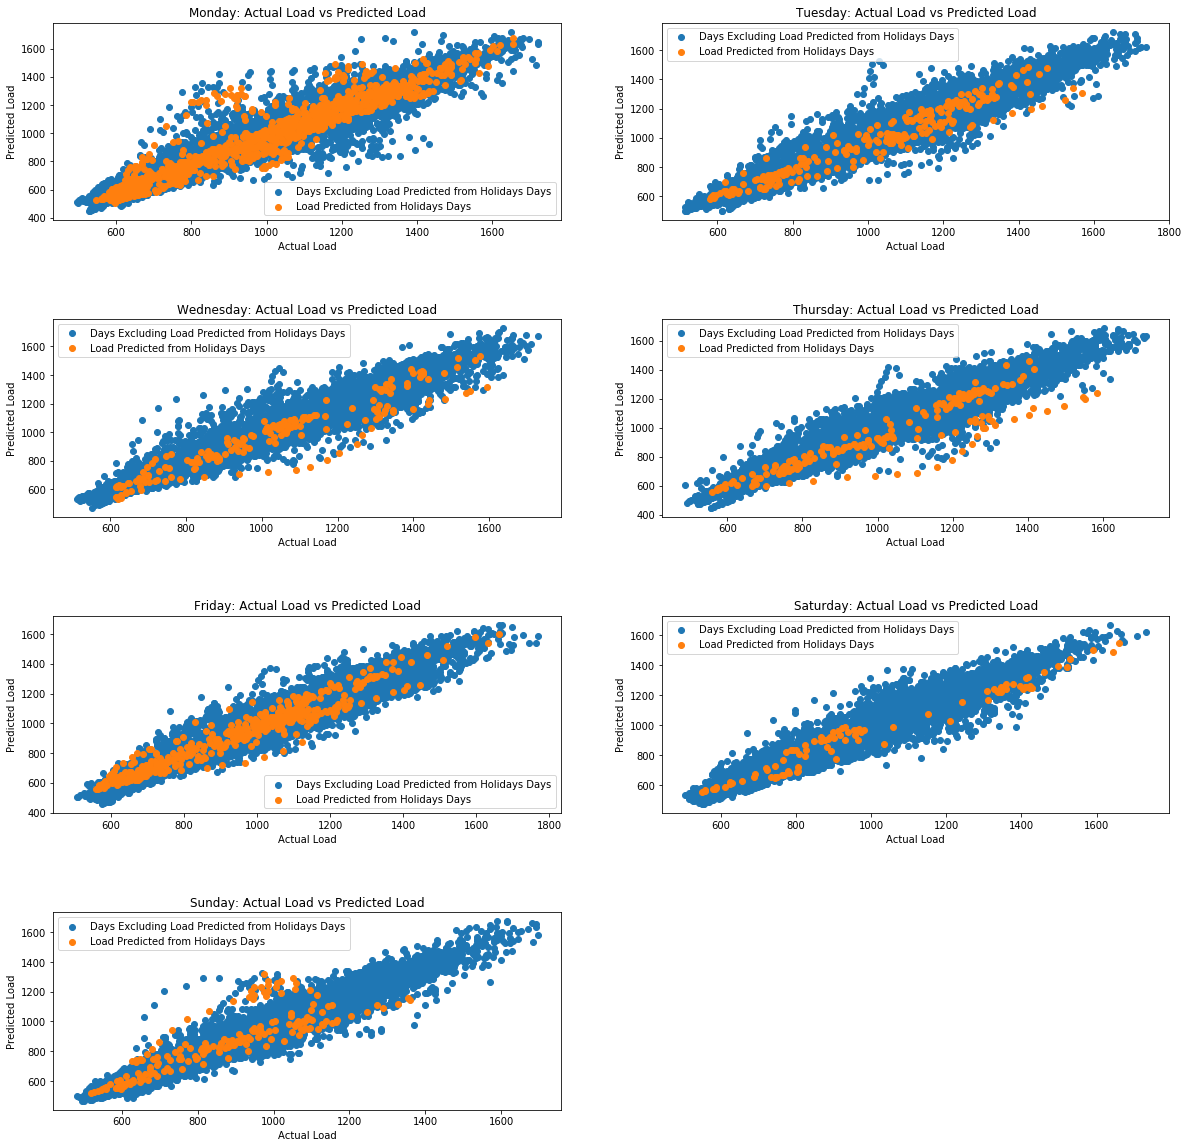

In [12]:
plt.figure(figsize=(20,20))

df_exclude_2018['Derived from Holiday'] = df_exclude_2018.apply(lambda row: is_derived_holiday(row), axis=1)
for i in range(0, 7):
    plt.subplot(4, 2, i+1)
    plt.title(i)
    specificday = df_exclude_2018[(df_exclude_2018['Dayofweek'] == i) & (df_exclude_2018['Derived from Holiday'] == False)]
    specificday_derived_holiday = df_exclude_2018[(df_exclude_2018['Dayofweek'] == i) & (df_exclude_2018['Derived from Holiday'] == True)]
    plt.scatter(specificday['Load Last Year'], specificday['Load'])
    plt.scatter(specificday_derived_holiday['Load Last Year'], specificday_derived_holiday['Load'])
    plt.title(f'{calendar.day_name[i]}: Actual Load vs Predicted Load')
    plt.ylabel('Predicted Load')
    plt.xlabel('Actual Load')
    plt.legend(['Days Excluding Load Predicted from Holidays Days','Load Predicted from Holidays Days'])
    correlation_specificday = specificday.corr()['Load']['Load Last Year']
    print(f'{calendar.day_name[i]} {correlation_specificday}')
    
plt.subplots_adjust(hspace = 0.5)

<b> Trend of underforecasting on days predicted load is from holiday days - could be because of 364 days meaning it is not a holiday </b>

Monday 0.9639962814027982
Tuesday 0.9690080113442786
Wednesday 0.9690240737280564
Thursday 0.9691234532168305
Friday 0.9693768725580468
Saturday 0.9662047257341911
Sunday 0.9700359415299702


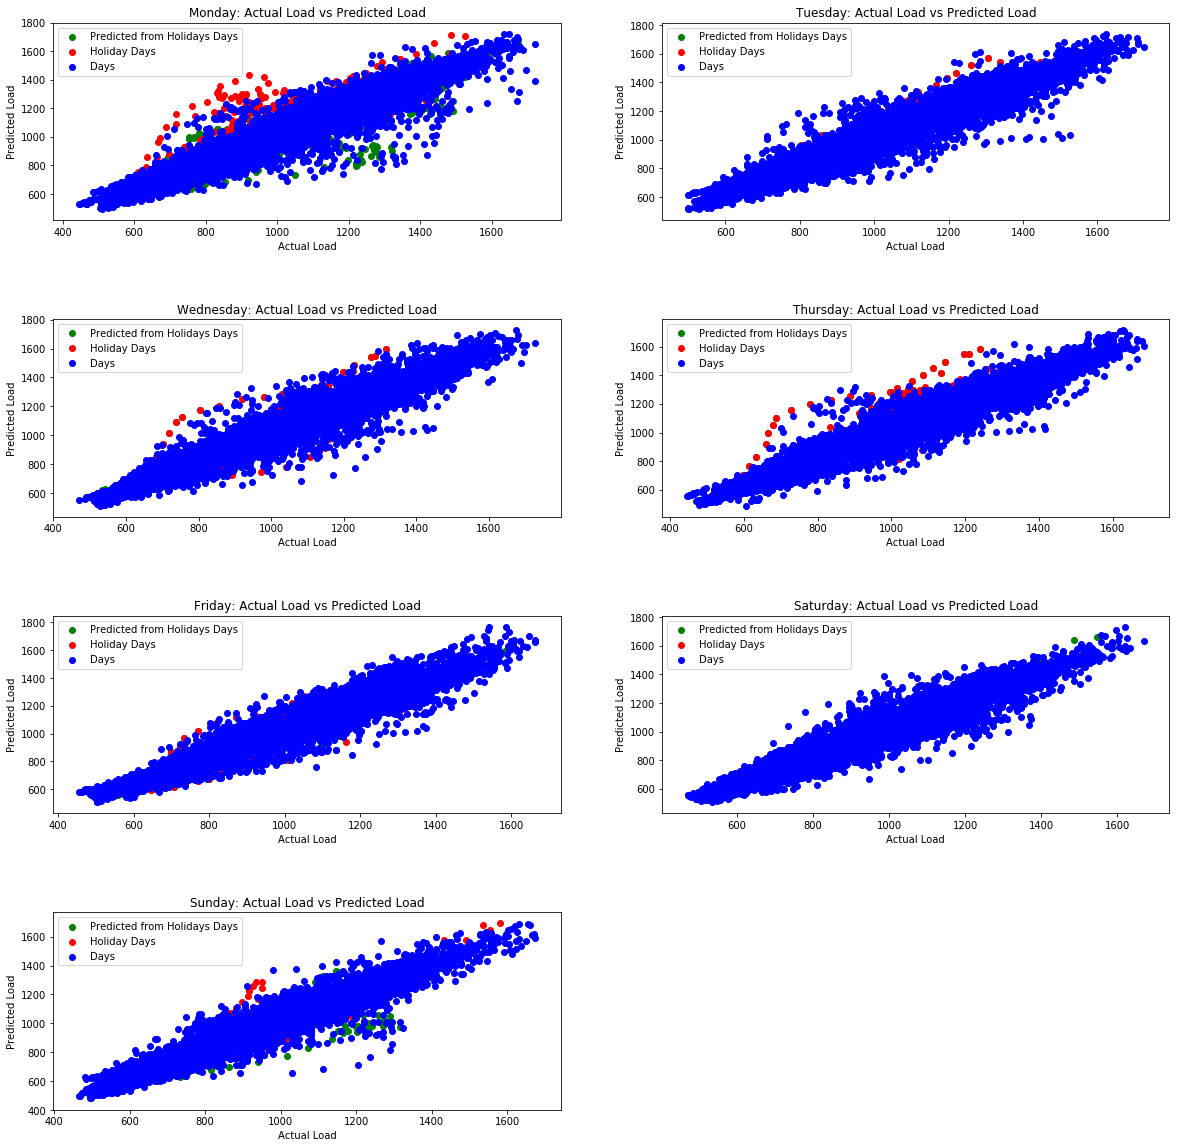

In [13]:
plt.figure(figsize=(20,20))

for i in range(0, 7):
    plt.subplot(4, 2, i+1)
    plt.title(i)
    specificday = df_exclude_2018[(df_exclude_2018['Dayofweek'] == i) & (df_exclude_2018['Derived from Holiday'] == False) & (df_exclude_2018['Holiday'] == False)]
    specificday_derived_holiday = df_exclude_2018[(df_exclude_2018['Dayofweek'] == i) & (df_exclude_2018['Derived from Holiday'] == True)]
    specificday_holiday = df_exclude_2018[(df_exclude_2018['Dayofweek'] == i) & (df_exclude_2018['Holiday'] == True)]
    plt.scatter(specificday_derived_holiday['Load'], specificday_derived_holiday['Load Last Year'], color='g')
    plt.scatter(specificday_holiday['Load'], specificday_holiday['Load Last Year'], color='r')
    plt.scatter(specificday['Load'], specificday['Load Last Year'], color='b')
    plt.title(f'{calendar.day_name[i]}: Actual Load vs Predicted Load')
    plt.ylabel('Predicted Load')
    plt.xlabel('Actual Load')
    plt.legend(['Predicted from Holidays Days', 'Holiday Days', 'Days'])
    correlation_specificday = specificday.corr()['Load']['Load Last Year']
    print(f'{calendar.day_name[i]} {correlation_specificday}')
    
plt.subplots_adjust(hspace = 0.5)

In [14]:
def is_observed_holiday(holidays):
    observed_holidays = {}
    for date, holiday in ni_holidays.items():
        if (holiday.__contains__('Observed')):
            observed_holidays[date] = holiday
    return observed_holidays

In [15]:
ni_holidays_observed = is_observed_holiday(ni_holidays)
ni_holidays_observed

{datetime.date(2016, 12, 27): 'Christmas Day (Observed)',
 datetime.date(2012, 1, 2): "New Year's Day (Observed)",
 datetime.date(2012, 3, 19): "St. Patrick's Day (Observed)",
 datetime.date(2013, 3, 18): "St. Patrick's Day (Observed)",
 datetime.date(2015, 12, 28): 'Boxing Day (Observed)',
 datetime.date(2017, 1, 2): "New Year's Day (Observed)"}

In [16]:
df_exclude_2018['Observed Holiday'] = df_exclude_2018['Date_Format'].isin(ni_holidays_observed)

C:\Users\jrbai\AppData\Local\conda\conda\envs\load_forecasting_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Excluding Holidays: 0.9683271653510257
Holidays excluding Observed: 0.8755463279268405
Observed Holidays: 0.8981952290940357


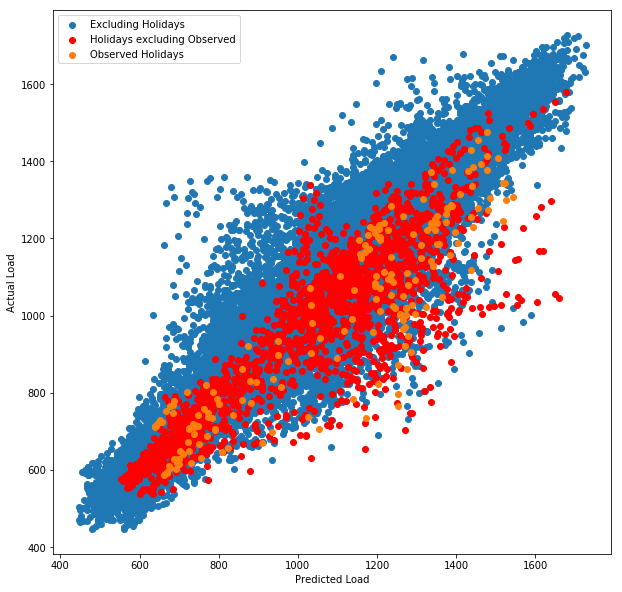

In [17]:
plt.figure(figsize=(10,10))

specificday_holiday = df_exclude_2018[(df_exclude_2018['Observed Holiday'] == False) & (df_exclude_2018['Holiday'] == True)]
specificday_observed_holiday = df_exclude_2018[(df_exclude_2018['Observed Holiday'] == True)]
specificday_exclude_holidays = df_exclude_2018[(df_exclude_2018['Holiday'] == False)]
#specificday_anomalous_data = df_exclude_2018[(df_exclude_2018['Holiday_Alternate'] == True)]
plt.scatter(specificday_exclude_holidays['Load Last Week'], specificday_exclude_holidays['Load'])
plt.scatter(specificday_holiday['Load Last Week'], specificday_holiday['Load'], color='r')
plt.scatter(specificday_observed_holiday['Load Last Week'], specificday_observed_holiday['Load'])
plt.xlabel('Predicted Load')
plt.ylabel('Actual Load')
plt.legend(['Excluding Holidays', 'Holidays excluding Observed', 'Observed Holidays'])
correlation_specificday_exclude_holiday = specificday_exclude_holidays.corr()['Load']['Load Last Week']
correlation_specificday_holiday = specificday_holiday.corr()['Load']['Load Last Week']
correlation_specificday_observed = specificday_observed_holiday.corr()['Load']['Load Last Week']
#correlation_specificday_anomalous_data = specificday_anomalous_data.corr()['Load']['Load Last Year']
print(f'Excluding Holidays: {correlation_specificday_exclude_holiday}')
print(f'Holidays excluding Observed: {correlation_specificday_holiday}')
print(f'Observed Holidays: {correlation_specificday_observed}')
#print(f'Anomalous Data: {correlation_specificday_anomalous_data}')
    
plt.subplots_adjust(hspace = 0.5)

Excluding Holidays: 0.9683271653510257
Holidays excluding Observed: 0.8755463279268405
Observed Holidays: 0.8981952290940357


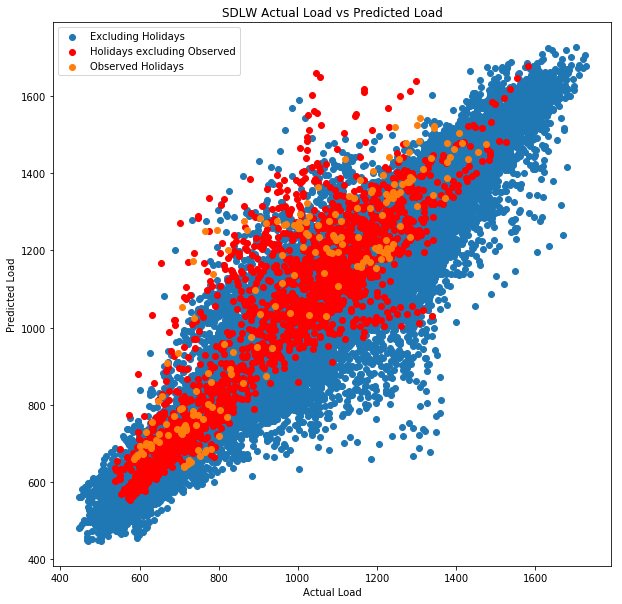

In [18]:
plt.figure(figsize=(10,10))

specificday_holiday = df_exclude_2018[(df_exclude_2018['Observed Holiday'] == False) & (df_exclude_2018['Holiday'] == True)]
specificday_observed_holiday = df_exclude_2018[(df_exclude_2018['Observed Holiday'] == True)]
specificday_exclude_holidays = df_exclude_2018[(df_exclude_2018['Holiday'] == False)]
plt.scatter(specificday_exclude_holidays['Load'], specificday_exclude_holidays['Load Last Week'])
plt.scatter(specificday_holiday['Load'], specificday_holiday['Load Last Week'], color='r')
plt.scatter(specificday_observed_holiday['Load'], specificday_observed_holiday['Load Last Week'])
plt.title('SDLW Actual Load vs Predicted Load')
plt.ylabel('Predicted Load')
plt.xlabel('Actual Load')
plt.legend(['Excluding Holidays', 'Holidays excluding Observed', 'Observed Holidays'])
correlation_specificday_exclude_holiday = specificday_exclude_holidays.corr()['Load']['Load Last Week']
correlation_specificday_holiday = specificday_holiday.corr()['Load']['Load Last Week']
correlation_specificday_observed = specificday_observed_holiday.corr()['Load']['Load Last Week']
print(f'Excluding Holidays: {correlation_specificday_exclude_holiday}')
print(f'Holidays excluding Observed: {correlation_specificday_holiday}')
print(f'Observed Holidays: {correlation_specificday_observed}')
    
plt.subplots_adjust(hspace = 0.5)

Excluding Holidays: 0.9320671334781764
Holidays excluding Observed: 0.8772669748565379
Observed Holidays: 0.9419299259516444


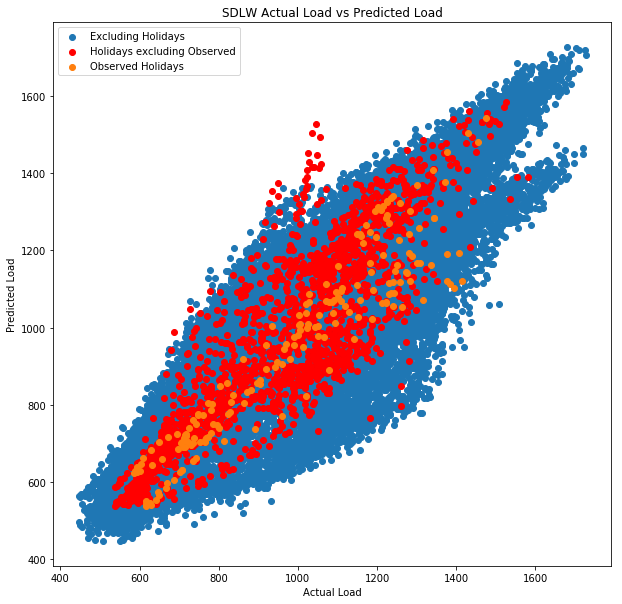

In [19]:
plt.figure(figsize=(10,10))

specificday_holiday = df_exclude_2018[(df_exclude_2018['Observed Holiday'] == False) & (df_exclude_2018['Holiday'] == True)]
specificday_observed_holiday = df_exclude_2018[(df_exclude_2018['Observed Holiday'] == True)]
specificday_exclude_holidays = df_exclude_2018[(df_exclude_2018['Holiday'] == False)]
plt.scatter(specificday_exclude_holidays['Load'], specificday_exclude_holidays['Load Last Day'])
plt.scatter(specificday_holiday['Load'], specificday_holiday['Load Last Day'], color='r')
plt.scatter(specificday_observed_holiday['Load'], specificday_observed_holiday['Load Last Day'])
plt.title('SDLW Actual Load vs Predicted Load')
plt.ylabel('Predicted Load')
plt.xlabel('Actual Load')
plt.legend(['Excluding Holidays', 'Holidays excluding Observed', 'Observed Holidays'])
correlation_specificday_exclude_holiday = specificday_exclude_holidays.corr()['Load']['Load Last Day']
correlation_specificday_holiday = specificday_holiday.corr()['Load']['Load Last Day']
correlation_specificday_observed = specificday_observed_holiday.corr()['Load']['Load Last Day']
print(f'Excluding Holidays: {correlation_specificday_exclude_holiday}')
print(f'Holidays excluding Observed: {correlation_specificday_holiday}')
print(f'Observed Holidays: {correlation_specificday_observed}')
    
plt.subplots_adjust(hspace = 0.5)

In [20]:
def set_holiday_day(row):
    holiday_status = row['Holiday']
    if holiday_status == True:
        return ni_holidays.get(row['Date_Format'])

df_exclude_2018['Holiday Day'] = df_exclude_2018.apply(lambda row: set_holiday_day(row), axis=1)

C:\Users\jrbai\AppData\Local\conda\conda\envs\load_forecasting_env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
def set_derived_holiday_day(row):
    holiday_derived_status = row['Derived from Holiday']
    if holiday_derived_status == True:
        date = row.Date
        derived_date = date - timedelta(minutes=10080)
        return ni_holidays.get(derived_date)
df_exclude_2018['Derived from Holiday Day'] = df_exclude_2018.apply(lambda row: set_derived_holiday_day(row), axis=1)

C:\Users\jrbai\AppData\Local\conda\conda\envs\load_forecasting_env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [22]:
df_holiday_days = df_exclude_2018[(df_exclude_2018['Holiday'] == True) | (df_exclude_2018['Derived from Holiday'] == True)]

Excluding Holiday and Derived from Holiday Day: 0.9700538827187495
Derived from Holiday Day: 0.9155715975347322


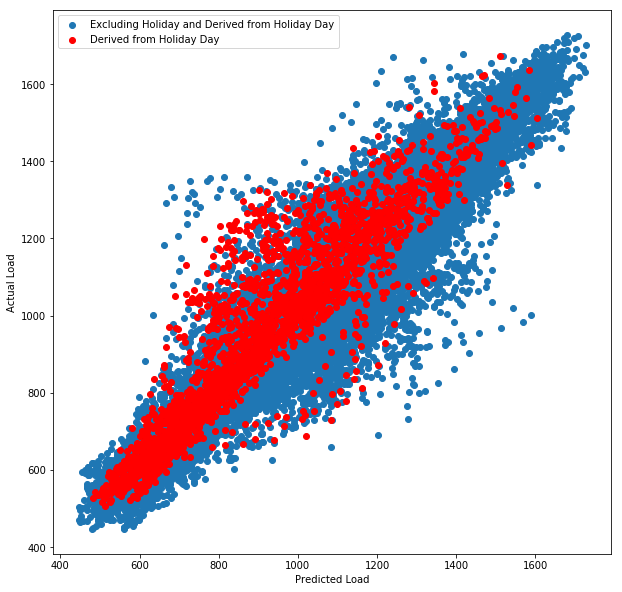

In [23]:
plt.figure(figsize=(10,10))

specificday_exclude_holidays = df_exclude_2018[(df_exclude_2018['Holiday'] == False) & (df_exclude_2018['Derived from Holiday'] == False)]
specificday_derived_holidays = df_exclude_2018[(df_exclude_2018['Derived from Holiday'] == True)]
plt.scatter(specificday_exclude_holidays['Load Last Week'], specificday_exclude_holidays['Load'])
plt.scatter(specificday_derived_holidays['Load Last Week'], specificday_derived_holidays['Load'], color='r')
plt.xlabel('Predicted Load')
plt.ylabel('Actual Load')
plt.legend(['Excluding Holiday and Derived from Holiday Day', 'Derived from Holiday Day'])
correlation_specificday_exclude_holiday = specificday_exclude_holidays.corr()['Load']['Load Last Week']
correlation_specificday_holiday = specificday_holiday.corr()['Load']['Load Last Week']
correlation_specificday_observed = specificday_observed_holiday.corr()['Load']['Load Last Week']
correlation_specificday_derived = specificday_derived_holidays.corr()['Load']['Load Last Week']
#correlation_specificday_anomalous_data = specificday_anomalous_data.corr()['Load']['Load Last Year']
print(f'Excluding Holiday and Derived from Holiday Day: {correlation_specificday_exclude_holiday}')
print(f'Derived from Holiday Day: {correlation_specificday_derived}')
#print(f'Anomalous Data: {correlation_specificday_anomalous_data}')
    
plt.subplots_adjust(hspace = 0.5)

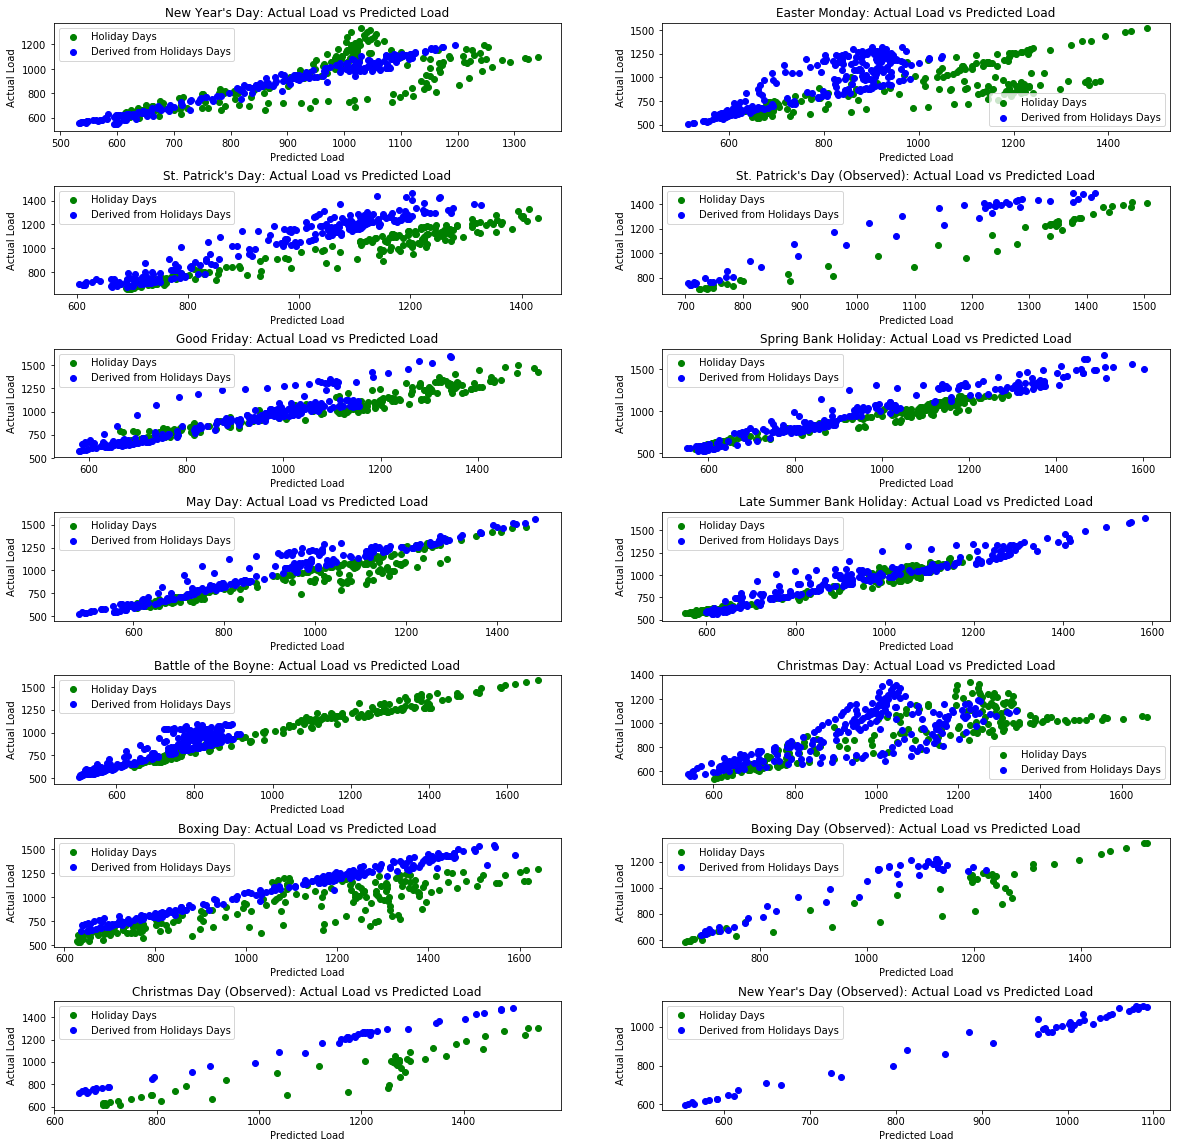

In [24]:
plt.figure(figsize=(20,20))
count = 1

holiday_days = df_holiday_days['Holiday Day'].dropna().unique().tolist()
derived_holiday_days = df_holiday_days['Derived from Holiday Day'].dropna().unique().tolist()
holiday_list = holiday_days + list(set(derived_holiday_days) - set(holiday_days))

holiday_correlation = {}
for i in holiday_list:
    plt.subplot(7, 2, count)
    count += 1
    plt.title(i)
    specificday_holiday = df_holiday_days[(df_holiday_days['Holiday Day'] == i)]
    specificday_derived_holiday = df_holiday_days[(df_holiday_days['Derived from Holiday Day'] == i)]
    plt.scatter(specificday_holiday['Load Last Week'], specificday_holiday['Load'], color='g')
    plt.scatter(specificday_derived_holiday['Load Last Week'], specificday_derived_holiday['Load'], color='b')
    plt.title(f'{i}: Actual Load vs Predicted Load')
    plt.xlabel('Predicted Load')
    plt.ylabel('Actual Load')
    plt.legend(['Holiday Days', 'Derived from Holidays Days'])
    correlation_specificday_holiday = specificday_holiday.corr()['Load']['Load Last Week']
    correlation_specificday_derived = specificday_derived_holiday.corr()['Load']['Load Last Week']
    holiday_correlation[f'Holiday {i}'] = correlation_specificday_holiday
    holiday_correlation[f'Derived {i}'] = correlation_specificday_derived
    
plt.subplots_adjust(hspace = 0.5)

In [25]:
corr_list = sorted(holiday_correlation.items(), key=itemgetter(1))

In [26]:
corr_list

[("Holiday New Year's Day", 0.7390984785656064),
 ('Derived Christmas Day', 0.74790754680361),
 ('Holiday Easter Monday', 0.7550115338325213),
 ('Holiday Christmas Day', 0.8201045599746379),
 ('Holiday Boxing Day', 0.8411661575418992),
 ('Derived Easter Monday', 0.8460693346423797),
 ('Derived Battle of the Boyne', 0.900766289532618),
 ('Derived Good Friday', 0.9112863397966736),
 ('Holiday Christmas Day (Observed)', 0.923448101902376),
 ('Holiday May Day', 0.9471857999312306),
 ('Holiday Boxing Day (Observed)', 0.949981565207958),
 ('Derived Late Summer Bank Holiday', 0.9610443239685775),
 ("Derived St. Patrick's Day", 0.9633160374878934),
 ('Holiday Good Friday', 0.9658235080222546),
 ('Derived Boxing Day (Observed)', 0.9658315284674125),
 ('Derived Spring Bank Holiday', 0.9666429995282139),
 ('Derived May Day', 0.9687816031547293),
 ("Holiday St. Patrick's Day", 0.9707316899268739),
 ('Holiday Late Summer Bank Holiday', 0.9793916961251217),
 ("Derived St. Patrick's Day (Observed)", 

In [27]:
for item in corr_list:
    print(item[1])

0.7390984785656064
0.74790754680361
0.7550115338325213
0.8201045599746379
0.8411661575418992
0.8460693346423797
0.900766289532618
0.9112863397966736
0.923448101902376
0.9471857999312306
0.949981565207958
0.9610443239685775
0.9633160374878934
0.9658235080222546
0.9658315284674125
0.9666429995282139
0.9687816031547293
0.9707316899268739
0.9793916961251217
0.9795384866266651
0.9805238843666723
0.9814658215200963
0.9863829408499677
0.9876591651779446
0.990997854715138
0.9970446608165575
nan
0.9942121305153343


In [28]:
holiday_correlation.values()

dict_values([0.7390984785656064, 0.9876591651779446, 0.7550115338325213, 0.8460693346423797, 0.9707316899268739, 0.9633160374878934, 0.9814658215200963, 0.9795384866266651, 0.9658235080222546, 0.9112863397966736, 0.9805238843666723, 0.9666429995282139, 0.9471857999312306, 0.9687816031547293, 0.9793916961251217, 0.9610443239685775, 0.9863829408499677, 0.900766289532618, 0.8201045599746379, 0.74790754680361, 0.8411661575418992, 0.990997854715138, 0.949981565207958, 0.9658315284674125, 0.923448101902376, 0.9970446608165575, nan, 0.9942121305153343])

In [29]:
# def correct_christmas(row):
#     holiday_derived = row['Derived from Holiday Day']
#     holiday = row['Holiday Day']
#     if holiday_derived == 'Christmas Day' or holiday == 'Christmas Day':
#         date = row.Date
#         derive_date = date - timedelta(minutes=525600)
#         predict_load = df[df.Date == derive_date].iloc[0]['Load']
#         return predict_load
#     return row['Load Last Year']

# df_holiday_days['Load Last Wee'] = df_holiday_days.apply(lambda row: correct_christmas(row), axis=1)

C:\Users\jrbai\AppData\Local\conda\conda\envs\load_forecasting_env\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


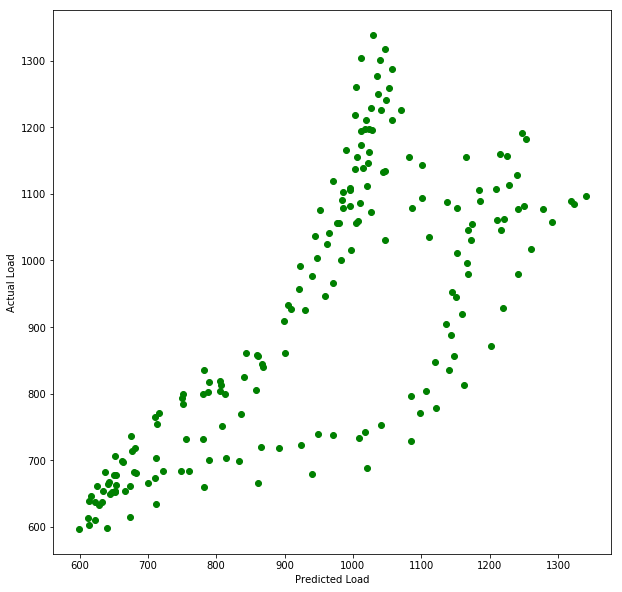

In [30]:
plt.figure(figsize=(10,10))
count = 1

holiday_list = ['New Year\'s Day']
holiday_correlation = {}
for i in holiday_list:
    plt.subplot(1, 1, count)
    count += 1
    specificday_holiday = df_holiday_days[(df_holiday_days['Holiday Day'] == i)]
    plt.scatter(specificday_holiday['Load Last Week'], specificday_holiday['Load'], color='g')
    plt.xlabel('Predicted Load')
    plt.ylabel('Actual Load')
    plt.savefig("NYDay_Holiday.svg", format="svg", bbox_inches='tight')
    plt.savefig("NYDay_Holiday.png", format="png", bbox_inches='tight')
plt.subplots_adjust(hspace = 0.5)

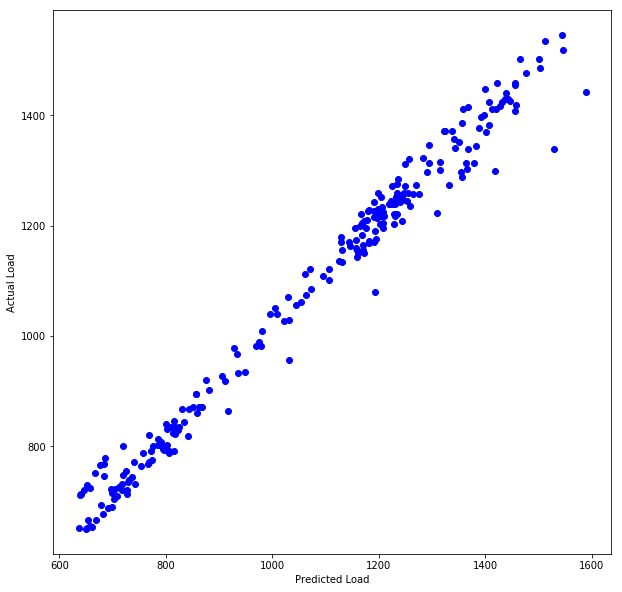

In [31]:
plt.figure(figsize=(10,10))
count = 1

holiday_list = ['Boxing Day']
holiday_correlation = {}
for i in holiday_list:
    plt.subplot(1, 1, count)
    count += 1
    specificday_derived_holiday = df_holiday_days[(df_holiday_days['Derived from Holiday Day'] == i)]
    plt.scatter(specificday_derived_holiday['Load Last Week'], specificday_derived_holiday['Load'], color='b')
    plt.xlabel('Predicted Load')
    plt.ylabel('Actual Load')
    plt.savefig("BoxingDay_Derived.svg", format="svg", bbox_inches='tight')
    plt.savefig("BoxingDay_Holiday.png", format="png", bbox_inches='tight')
    
plt.subplots_adjust(hspace = 0.5)

In [32]:
sorted(holiday_correlation.items(), key=itemgetter(1))

[]

In [33]:
def correct_christmas_period(row):
    holiday_derived = row['Derived from Holiday Day']
    holiday = row['Holiday Day']
    christmas_period_holidays = ['New Year\'s Day', 'Boxing Day', 'Christmas Day']
    if holiday_derived in christmas_period_holidays or holiday in christmas_period_holidays:
        date = row.Date
        derive_date = date - timedelta(minutes=525600)
        predict_load = df[df.Date == derive_date].iloc[0]['Load']
        return predict_load
    return row['Load Last Week']

df_holiday_days['Load Last Week'] = df_holiday_days.apply(lambda row: correct_christmas_period(row), axis=1)

C:\Users\jrbai\AppData\Local\conda\conda\envs\load_forecasting_env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


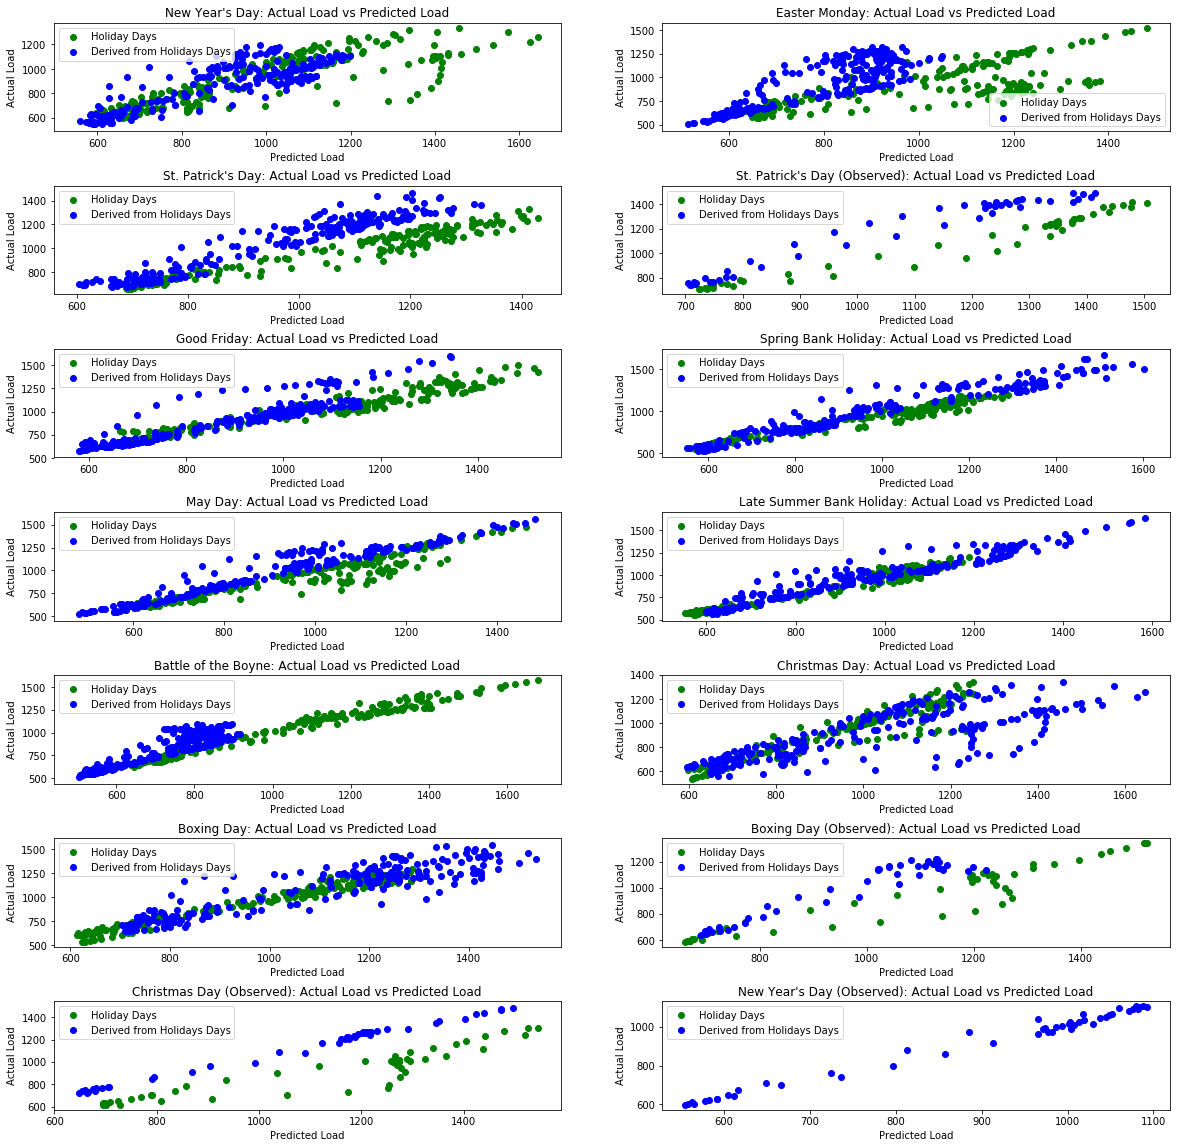

In [34]:
plt.figure(figsize=(20,20))
count = 1

holiday_days = df_holiday_days['Holiday Day'].dropna().unique().tolist()
derived_holiday_days = df_holiday_days['Derived from Holiday Day'].dropna().unique().tolist()
holiday_list = holiday_days + list(set(derived_holiday_days) - set(holiday_days))

holiday_correlation = {}
for i in holiday_list:
    plt.subplot(7, 2, count)
    count += 1
    plt.title(i)
    specificday_holiday = df_holiday_days[(df_holiday_days['Holiday Day'] == i)]
    specificday_derived_holiday = df_holiday_days[(df_holiday_days['Derived from Holiday Day'] == i)]
    plt.scatter(specificday_holiday['Load Last Week'], specificday_holiday['Load'], color='g')
    plt.scatter(specificday_derived_holiday['Load Last Week'], specificday_derived_holiday['Load'], color='b')
    plt.title(f'{i}: Actual Load vs Predicted Load')
    plt.xlabel('Predicted Load')
    plt.ylabel('Actual Load')
    plt.legend(['Holiday Days', 'Derived from Holidays Days'])
    correlation_specificday_holiday = specificday_holiday.corr()['Load']['Load Last Week']
    correlation_specificday_derived = specificday_derived_holiday.corr()['Load']['Load Last Week']
    holiday_correlation[f'Holiday {i}'] = correlation_specificday_holiday
    holiday_correlation[f'Derived {i}'] = correlation_specificday_derived
    
plt.subplots_adjust(hspace = 0.5)

In [35]:
corr_list = sorted(holiday_correlation.items(), key=itemgetter(1))

In [36]:
corr_list

[('Holiday Easter Monday', 0.7550115338325213),
 ('Derived Christmas Day', 0.7880122301113228),
 ("Holiday New Year's Day", 0.8330742552011607),
 ('Derived Easter Monday', 0.8460693346423797),
 ("Derived New Year's Day", 0.8536794834433642),
 ('Derived Battle of the Boyne', 0.900766289532618),
 ('Derived Boxing Day', 0.9098157330683067),
 ('Derived Good Friday', 0.9112863397966736),
 ('Holiday Christmas Day (Observed)', 0.923448101902376),
 ('Holiday Christmas Day', 0.9409138819705751),
 ('Holiday May Day', 0.9471857999312306),
 ('Holiday Boxing Day (Observed)', 0.949981565207958),
 ('Derived Late Summer Bank Holiday', 0.9610443239685775),
 ("Derived St. Patrick's Day", 0.9633160374878934),
 ('Holiday Good Friday', 0.9658235080222546),
 ('Derived Boxing Day (Observed)', 0.9658315284674125),
 ('Derived Spring Bank Holiday', 0.9666429995282139),
 ('Derived May Day', 0.9687816031547293),
 ("Holiday St. Patrick's Day", 0.9707316899268739),
 ('Holiday Late Summer Bank Holiday', 0.9793916961

In [37]:
# def correct_easter(row):
#     holiday_derived = row['Derived from Holiday Day']
#     holiday = row['Holiday Day']
#     if holiday_derived == 'Easter Monday' or holiday == 'Easter Monday':
#         date = row.Date
#         derive_date = date - timedelta(minutes=525600)
#         predict_load = df[df.Date == derive_date].iloc[0]['Load']
#         return predict_load
#     return row['Load Last Year']

# df_holiday_days['Load Last Year'] = df_holiday_days.apply(lambda row: correct_easter(row), axis=1)

In [38]:
# plt.figure(figsize=(20,20))
# count = 1

# holiday_list = ['Easter Monday']
# holiday_correlation = {}
# for i in holiday_list:
#     plt.subplot(2, 1, count)
#     count += 1
#     plt.title(i)
#     specificday_holiday = df_holiday_days[(df_holiday_days['Holiday Day'] == i)]
#     specificday_derived_holiday = df_holiday_days[(df_holiday_days['Derived from Holiday Day'] == i)]
#     plt.scatter(specificday_holiday['Load'], specificday_holiday['Load Last Year'], color='g')
#     plt.scatter(specificday_derived_holiday['Load'], specificday_derived_holiday['Load Last Year'], color='b')
#     plt.title(f'{i}: Actual Load vs Predicted Load')
#     plt.ylabel('Predicted Load')
#     plt.xlabel('Actual Load')
#     plt.legend(['Holiday Days', 'Derived from Holidays Days'])
#     correlation_specificday_holiday = specificday_holiday.corr()['Load']['Load Last Year']
#     correlation_specificday_derived = specificday_derived_holiday.corr()['Load']['Load Last Year']
#     holiday_correlation[f'Holiday {i}'] = correlation_specificday_holiday
#     holiday_correlation[f'Derived {i}'] = correlation_specificday_derived
    
# plt.subplots_adjust(hspace = 0.5)

In [39]:
# sorted(holiday_correlation.items(), key=itemgetter(1))

Range of dates for Western and Orthodox Easter. Both calendars (Gregorian and Julian) calculate Easter as falling on dates between March 22 and April 25 on their calendars.

In [40]:
# def correct_easter_derived(row):
#     holiday_derived = row['Derived from Holiday Day']
#     holiday = row['Holiday Day']
#     if holiday_derived == 'Easter Monday':
#         date = row.Date
#         derive_date = date - timedelta(minutes=534240) #53 weeks
#         predict_load = df[df.Date == derive_date].iloc[0]['Load']
#         return predict_load
#     return row['Load Last Year']

# df_holiday_days['Load Last Year'] = df_holiday_days.apply(lambda row: correct_easter_derived(row), axis=1)

In [41]:
# plt.figure(figsize=(20,20))
# count = 1

# holiday_list = ['Easter Monday']
# holiday_correlation = {}
# for i in holiday_list:
#     plt.subplot(2, 1, count)
#     count += 1
#     plt.title(i)
#     specificday_holiday = df_holiday_days[(df_holiday_days['Holiday Day'] == i)]
#     specificday_derived_holiday = df_holiday_days[(df_holiday_days['Derived from Holiday Day'] == i)]
#     plt.scatter(specificday_holiday['Load'], specificday_holiday['Load Last Year'], color='g')
#     plt.scatter(specificday_derived_holiday['Load'], specificday_derived_holiday['Load Last Year'], color='b')
#     plt.title(f'{i}: Actual Load vs Predicted Load')
#     plt.ylabel('Predicted Load')
#     plt.xlabel('Actual Load')
#     plt.legend(['Holiday Days', 'Derived from Holidays Days'])
#     correlation_specificday_holiday = specificday_holiday.corr()['Load']['Load Last Year']
#     correlation_specificday_derived = specificday_derived_holiday.corr()['Load']['Load Last Year']
#     holiday_correlation[f'Holiday {i}'] = correlation_specificday_holiday
#     holiday_correlation[f'Derived {i}'] = correlation_specificday_derived
    
# plt.subplots_adjust(hspace = 0.5)

In [42]:
# sorted(holiday_correlation.items(), key=itemgetter(1))